# Data Loading

In [1]:
%load_ext kedro.ipython

[04/17/24 13:15:24] INFO     Registered line magic '%reload_kedro'                                   ]8;id=369467;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=111438;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/site-packages/kedro/ipython/__init__.py#51\51]8;;\

                    INFO     Registered line magic '%load_node'                                      ]8;id=766959;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=771342;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/site-packages/kedro/ipython/__init__.py#53\53]8;;\

                    INFO     Resolved project path as:                                              ]8;id=645391;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=801576;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/site-packages/kedro/ipython/__init__.py#164\164]8;;\
                             /mnt/c/Users/hi/work/project/depok-houseprice.                                        
                             To set a different path, run '%reload_kedro <project_root>'                           

[04/17/24 13:15:26] INFO     Kedro project depok-houseprice-predict                                 ]8;id=215329;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=723210;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=757662;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=975871;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/site-packages/kedro/ipython/__init__.py#135\135]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=796489;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=159827;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/site-packages/kedro/ipython/__init__.py#141\141]8;;\

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split

pd.options.display.max_colwidth = 150

In [3]:
houseprice = catalog.load("housedata")

# X = houseprice.drop(columns='price', axis=1)
# y = houseprice['price']

[04/17/24 13:15:27] INFO     Loading data from housedata (CSVDataset)...                        ]8;id=183608;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=494578;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/site-packages/kedro/io/data_catalog.py#483\483]8;;\

In [4]:
houseprice.shape

(8113, 17)

In [5]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# train = houseprice.iloc[:6489,]
# test = houseprice.iloc[6489:,]

# train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
# test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

# dfs = [train, test]

In [6]:
# train.head()

In [7]:
# test.shape

In [8]:
# train.info()

all of the columns are object dtype, so we need to change some of them into:
- int: bedrooms, bathrooms, num_floors
- float: price, building_size, land_size

In [9]:
import re
from typing import Any, Dict, List
import pandas as pd
import numpy as np
from math import ceil
from scipy.stats import skew


def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """Change datatype while ignoring missing value

    Args:
        df (pd.DataFrame): all numeric features of data

    Returns:
        pd.DataFrame: fixed data types numeric features
    """

    for column in ["bedrooms", "bathrooms", "num_floors", "price"]:
        if not pd.api.types.is_numeric_dtype(df[column]):
            df[column] = pd.to_numeric(df[column], errors="coerce").astype(
                int, errors="ignore"
            )

    for column in ["building_size", "land_size"]:
        if not pd.api.types.is_numeric_dtype(df[column]):
            df[column] = pd.to_numeric(df[column], errors="coerce").astype(
                float, errors="ignore"
            )

    return df


def parse_subcategories(x: pd.Series) -> pd.Series:
    """parse subcategories columns and pick only second element of list
    example:
        ["house","single-family-house"] to "single-family-house"


    Args:
        x (pd.Series): original subcategories column

    Returns:
        pd.Series: parse result of subcategories
    """
    x = x.apply(lambda x: x.replace("[", "").replace("]", "").replace('"', "").split(",")[1])
    return x


def prep_location(x: pd.Series) -> pd.Series:
    """parse parent_url column to get house location
    example:
        https://www.lamudi.co.id/west-java/depok/cimanggis/house/buy/ to "cimanggis"
        https://www.lamudi.co.id/west-java/depok/sawangan-1/house/buy/ to "sawangan"

    Args:
        x (pd.Series): page url features of data

    Returns:
        pd.Series: location parsed from page url
    """
    x = x.apply(lambda x: re.sub("-?\d+", "", x.split("/")[5]).replace("-", " "))
    return x


def calculate_floors(
    floors: pd.Series, building_land_div: pd.Series, url: pd.Series
) -> pd.Series:
    """calculate and fix num_floors by either from url or result of division of building_size and land_size

    Args:
        floors (pd.Series): number of floor values
        building_land_div (pd.Series): division of building_size and land_size
        url (pd.Series): webpage url of house

    Returns:
        pd.Series: Results of number of floor
    """
    floor_pattern = "(\\d+).?(lantai|lt)"
    floors_by_pattern = url.apply(
        lambda x: (
            int(re.search(floor_pattern, x)[1]) if re.search(floor_pattern, x) else 0
        )
    )

    floors_by_size = np.vectorize(ceil)(building_land_div)

    # Use conditional logic to determine floors based on pattern and size constraints
    floors = np.where(
        (floors_by_pattern != 0) & (floors_by_pattern < 5),
        floors_by_pattern,
        floors_by_size,
    )

    # No need to drop columns as they weren't created directly
    return floors.astype(int)


def prep_furnished(x: pd.Series) -> pd.Series:
    """Map furnished values to either yes, no, or semi

    Args:
        x (pd.Series): furnished feature of data

    Returns:
        pd.Series: Mapping result of furnished values
    """
    furnished_map = {"11": "yes", "123": "no", "124": "semi"}
    x = x.map(furnished_map)
    return x.fillna('no')


def prep_facility(df: pd.DataFrame) -> pd.DataFrame:
    """preprocessed facility columns

    Args:
        df (pd.DataFrame): house facility of dataset

    Returns:
        pd.DataFrame: 'yes' if house has feature and 'no' if house does not have feature
    """
    facility = ["ac_unit", "balcony", "yard", "security", "pool"]

    return df[facility] == "yes"


def log_transformation(df: pd.DataFrame) -> pd.DataFrame:
    """address the issue of skewed features using log transformation

    Args:
        df (pd.DataFrame): extremely skewed features of data

    Returns:
        pd.DataFrame: log result of skewed data
    """
    cols = df[["building_size", "land_size", "price"]]
    skewed_train = cols.apply(lambda x: skew(x.dropna()))
    skewed_train = skewed_train[skewed_train > 0.75]
    df[skewed_train.index] = np.log1p(df[skewed_train.index])

    return df


def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """Process the data for model training

    Args:
        df (pd.DataFrame): dataset used to build machine learning model

    Returns:
        pd.DataFrame: preprocessed dataset
    """
    # "bedrooms", "bathrooms", "num_floors", "price", "building_size", "land_size"
    df = convert_dtypes(df)
    # subcategories
    df["subcategories"] =  parse_subcategories(df["subcategories"])
    # locations
    df["location"] = prep_location(df["parent_url"])
    # furnished
    df["furnished"] = prep_furnished(df["furnished"])
    # house facility
    facility = ["ac_unit", "balcony", "yard", "security", "pool"]
    df[facility] = prep_facility(df[facility])
    # num_floors
    # df["building_land_ratio"] = df["building_size"] / df["land_size"]
    df["num_floors"] = calculate_floors(
        df["num_floors"], df["building_size"] / df["land_size"], df["page_url"]
    )
    df = log_transformation(df)

    return df


def train_test_split(prep_df: pd.DataFrame):
    """Split processed data into train and test sets

    Args:
        prep_df (pd.DataFrame): DataFrame containing the processed house dataset

    Returns:
        Tuple: train data, train labels, test data, and test labels
    """
    train_df = prep_df.iloc[:6489,]
    test_df = prep_df.iloc[6489:,]

    test_df = test_df.reset_index(drop=True)

    X_train = train_df.drop(
        columns=["price", "categories", "geo_point", "page_url", "parent_url"], axis=1
    )
    y_train = train_df["price"]

    X_test = test_df.drop(
        columns=["price", "categories", "geo_point", "page_url", "parent_url"], axis=1
    )
    y_test = test_df["price"]

    return (
        X_train,
        y_train,
        X_test,
        y_test,
    )


In [10]:
houseprice.head()

,categories,subcategories,bedrooms,bathrooms,building_size,land_size,num_floors,furnished,geo_point,page_url,parent_url,ac_unit,balcony,yard,security,pool,price
0,house,"[""house"",""single-family-house""]",4,2,200.0,1115.0,NaN,NaN,"[106.81139,-6.38417]",https://www.lamudi.co.id/rumah-second-tanah-luas-1115m2-dekat-tol-kukusan-b-170347388618.html,https://www.lamudi.co.id/west-java/depok/beji-3/house/buy/,NaN,NaN,yes,NaN,NaN,7805000000
1,house,"[""house"",""townhouse""]",2,2,70.0,65.0,NaN,NaN,"[106.77444,-6.40278]",https://www.lamudi.co.id/rumah-syariah-murah-di-pinggir-jalan-raya-permata-169579302118.html,https://www.lamudi.co.id/west-java/depok/sawangan-1/house/buy/,NaN,NaN,yes,yes,NaN,720000000
2,house,"[""house"",""single-family-house""]",3,2,80.0,131.0,1.0,NaN,"[106.84333,-6.42694]",https://www.lamudi.co.id/rumah-murah-di-gdc-cluster-puri-insani-1-kalimulya-170372834840.html,https://www.lamudi.co.id/west-java/depok/cilodong/house/buy/,NaN,NaN,yes,yes,NaN,850000000
3,house,"[""house"",""townhouse""]",3,1,52.0,70.0,NaN,NaN,"[106.8118296,-6.4452406]",https://www.lamudi.co.id/rumah-3-kamar-tidur-2-lantai-termurah-dekat-ke-sta-169693741318.html,https://www.lamudi.co.id/west-java/depok/citayam/house/buy/,yes,yes,yes,yes,NaN,400000000
4,house,"[""house"",""single-family-house""]",2,1,36.0,78.0,NaN,NaN,"[106.8929,-6.40092]",https://www.lamudi.co.id/perumahan-dp-50jt-cicilan-mulai-4jtan-di-cimanggis-17092790459.html,https://www.lamudi.co.id/west-java/depok/beji-3/house/buy/,NaN,NaN,yes,NaN,NaN,688888888


In [11]:
df = preprocess_data(houseprice)

# Modelling

In [12]:
from scipy.stats import skew

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import RANSACRegressor, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

In [14]:
X_train, y_train, X_test, y_test = train_test_split(df)

In [15]:
X_train

,subcategories,bedrooms,bathrooms,building_size,land_size,num_floors,furnished,ac_unit,balcony,yard,security,pool,location
0,single-family-house,4,2,5.303305,7.017506,1,no,False,False,True,False,False,beji
1,townhouse,2,2,4.262680,4.189655,2,no,False,False,True,True,False,sawangan
2,single-family-house,3,2,4.394449,4.882802,1,no,False,False,True,True,False,cilodong
3,townhouse,3,1,3.970292,4.262680,2,no,True,True,True,True,False,citayam
4,single-family-house,2,1,3.610918,4.369448,1,no,False,False,True,False,False,beji
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6484,single-family-house,3,2,4.615121,5.525453,1,no,False,False,False,False,False,pancoran mas
6485,single-family-house,3,3,5.017280,4.672829,2,no,False,False,True,True,False,pancoran mas
6486,single-family-house,4,5,5.602119,5.198497,2,no,False,False,True,True,False,cimanggis
6487,single-family-house,2,1,4.110874,3.663562,2,no,True,False,True,True,False,cilodong


In [16]:
X_test

,subcategories,bedrooms,bathrooms,building_size,land_size,num_floors,furnished,ac_unit,balcony,yard,security,pool,location
0,single-family-house,3,2,4.143135,4.624973,1,no,False,False,False,False,False,cimanggis
1,single-family-house,4,3,5.017280,5.416100,1,no,False,False,False,False,False,pancoran mas
2,single-family-house,3,2,4.919981,5.303305,1,no,False,False,False,False,False,cinere
3,single-family-house,4,3,4.795791,5.398163,1,no,False,False,True,True,False,pancoran mas
4,single-family-house,2,1,3.433987,3.713572,1,no,False,False,False,False,False,cipayung
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,single-family-house,2,1,3.828641,4.158883,1,no,False,False,False,False,False,citayam
1620,single-family-house,3,2,4.189655,4.700480,1,no,True,False,True,True,False,sukmajaya
1621,single-family-house,3,2,4.615121,4.897840,2,no,False,False,True,True,False,sawangan
1622,single-family-house,3,2,4.110874,4.158883,2,no,False,False,True,True,False,cimanggis


In [17]:
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('encode', OneHotEncoder(handle_unknown='ignore'))
    # ('encode', OneHotEncoder())
])

numeric_features = X_train.select_dtypes(include=['float', 'int']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, numeric_features),
        ('cat', cat_pipe, categorical_features)
    ])

In [18]:
# X_test = test.drop(columns=['price', 'categories', 'geo_point', 'page_url', 'parent_url'], axis=1)
# y_test = test['price']

In [19]:
# # ubah yes/no menjadi 1/0
# X_test['security'] = X_test['security'].apply(lambda x: 1 if x == 'yes' else 0)
# X_test['yard'] = X_test['yard'].apply(lambda x: 1 if x == 'yes' else 0)
# X_test['balcony'] = X_test['balcony'].apply(lambda x: 1 if x == 'yes' else 0)
# X_test['ac_unit'] = X_test['ac_unit'].apply(lambda x: 1 if x == 'yes' else 0)
# X_test['pool'] = X_test['pool'].apply(lambda x: 1 if x == 'yes' else 0)

[04/17/24 13:17:12] WARNING  /tmp/ipykernel_54637/926544376.py:23: FutureWarning: The behavior of   ]8;id=137027;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=147503;file:///home/anggapark/miniconda3/envs/depok-house-pred/lib/python3.10/warnings.py#109\109]8;;\
                             DataFrame concatenation with empty or all-NA entries is deprecated. In                
                             a future version, this will no longer exclude empty or all-NA columns                 
                             when determining the result dtypes. To retain the old behavior,                       
                             exclude the relevant entries before the concat operation.                             
                               results_df = pd.concat([results_df, pd.DataFrame([{'Model':                         
                             model_name, 'RMSE': rmse, 'MAE': mae}])], ignore_index=True)                          
                                                                                                                   

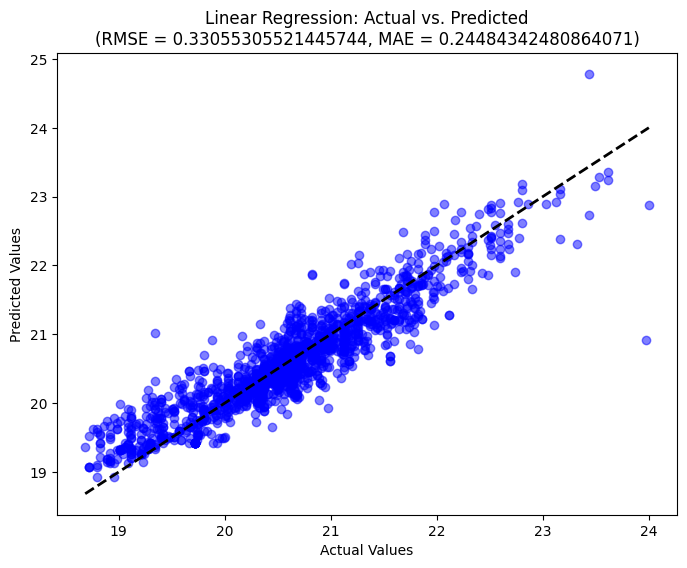

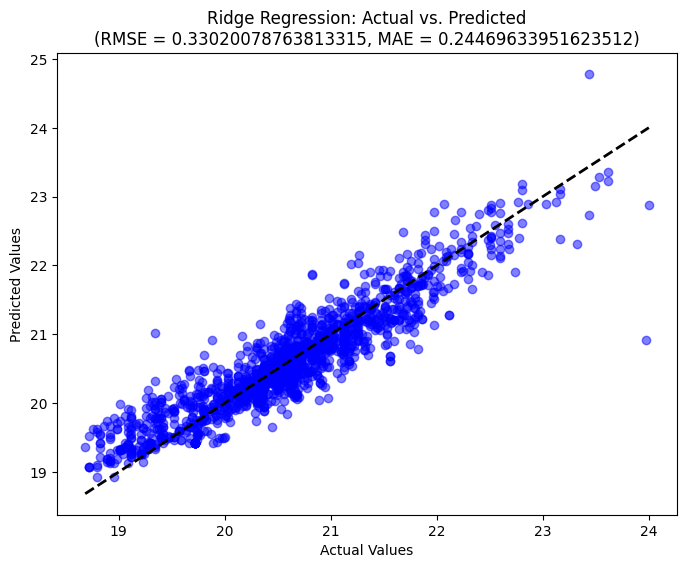

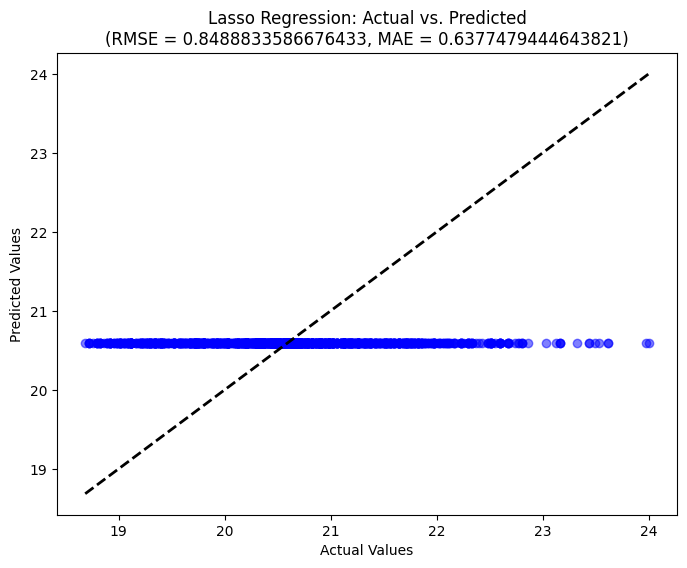

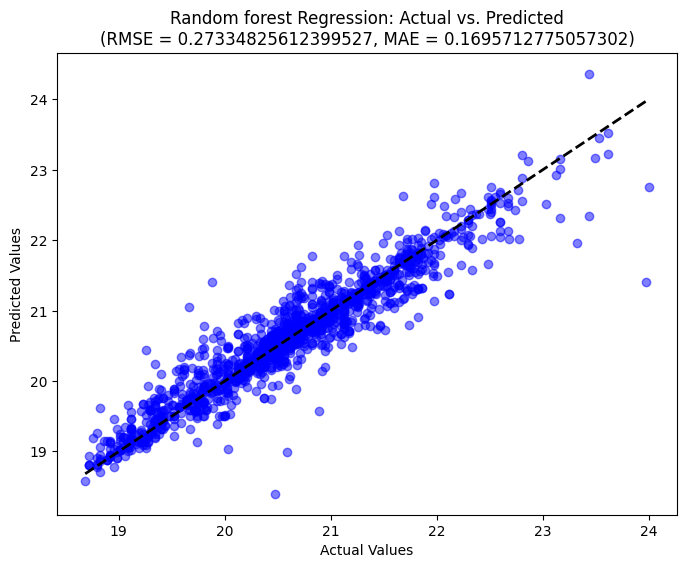

In [20]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    # ('RANSAC Regression', RANSACRegressor()),
    ('Random forest Regression', RandomForestRegressor())
]

results_df = pd.DataFrame(columns=['Model', 'RMSE', 'MAE'])

for model_name, model in models:
    pipeline = Pipeline([
        ('Preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    # results_df = results_df._append({'Model': model_name, 'RMSE': rmse, 'MAE': mae}, ignore_index=True)
    results_df = pd.concat([results_df, pd.DataFrame([{'Model': model_name, 'RMSE': rmse, 'MAE': mae}])], ignore_index=True)
    # new_rows = [{'Model': model_name, 'RMSE': rmse, 'MAE': mae} for model_name, model in models]
    # results_df = pd.DataFrame(new_rows)
    
    # Visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, c='blue', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{model_name}: Actual vs. Predicted\n(RMSE = {rmse}, MAE = {mae})")
    plt.show()

In [21]:
results_df

,Model,RMSE,MAE
0,Linear Regression,0.330553,0.244843
1,Ridge Regression,0.330201,0.244696
2,Lasso Regression,0.848883,0.637748
3,Random forest Regression,0.273348,0.169571


In [133]:
# results_df

,Model,RMSE,MAE
0,Linear Regression,0.328160,0.239027
1,Ridge Regression,0.328090,0.238986
2,Lasso Regression,0.849127,0.637996
3,Random forest Regression,0.273380,0.170862


## Hyperparameter tuning

In [121]:
pipeline = Pipeline([
    ('Preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['bedrooms', 'bathrooms', 'building_size', 'land_size', 'num_floors',
       'ac_unit', 'balcony', 'yard', 'security', 'pool'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['subcategories', 'furnished', 'location'], dtype='object'))])),
                ('model', RandomForestRegressor())])

In [122]:
# periksa setiap parameter yang terlibat dalam pembentukan model
pipeline.get_params()


{
    'memory': None,
    'steps': [
        (
            'Preprocessor',
            ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['bedrooms', 'bathrooms', 'building_size', 'land_size', 'num_floors',
       'ac_unit', 'balcony', 'yard', 'security', 'pool'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['subcategories', 'furnished', 'location'], dtype='object'))])
        ),
        ('model', RandomForestRegressor())
    ],
    'verbose': False,
    'Preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['bedrooms', 'bathrooms', 'building_size',

In [123]:
params = {'model__n_estimators':[25, 50, 100, 150],
          'model__max_depth':[None, 3, 6, 9],
          'model__min_samples_split':[2, 4, 8, 16],
          'model__max_leaf_nodes': [None, 3, 6, 9]
    }

model = GridSearchCV(pipeline, 
                     param_grid=params, 
                     cv=3, 
                     n_jobs=-1, 
                     verbose=1
                    )

model.fit(X_train, y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['bedrooms', 'bathrooms', 'building_size', 'land_size', 'num_floors',
       'ac_unit', 'balcony', 'yard', 'security', 'pool'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encode',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['subcategories', 'furnished', 'location'], dtype='object'))])),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 3, 6, 9],
                         'model__max_leaf_nodes': [None, 3, 6, 9],
                         'model__min_samples_split': [2, 4, 8, 16],
                         'model__n_estimators': [25, 50, 100, 150]},
             verbose=1)

In [124]:
pd.DataFrame(model.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__max_leaf_nodes,param_model__min_samples_split,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,2.412624,0.038615,0.066781,0.003718,None,None,4,150,"{'model__max_depth': None, 'model__max_leaf_nodes': None, 'model__min_samples_split': 4, 'model__n_estimators': 150}",0.888797,0.895259,0.893459,0.892505,0.002723,1
11,1.742949,0.029110,0.058294,0.003617,None,None,8,150,"{'model__max_depth': None, 'model__max_leaf_nodes': None, 'model__min_samples_split': 8, 'model__n_estimators': 150}",0.888879,0.895259,0.892737,0.892291,0.002624,2
6,1.707704,0.013111,0.053831,0.001817,None,None,4,100,"{'model__max_depth': None, 'model__max_leaf_nodes': None, 'model__min_samples_split': 4, 'model__n_estimators': 100}",0.887470,0.895263,0.892587,0.891773,0.003233,3
3,2.861188,0.046047,0.075198,0.007804,None,None,2,150,"{'model__max_depth': None, 'model__max_leaf_nodes': None, 'model__min_samples_split': 2, 'model__n_estimators': 150}",0.889132,0.894953,0.891056,0.891714,0.002422,4
2,1.952995,0.007676,0.062653,0.001697,None,None,2,100,"{'model__max_depth': None, 'model__max_leaf_nodes': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}",0.888911,0.894025,0.891966,0.891634,0.002101,5


In [125]:
model.best_params_


{
    'model__max_depth': None,
    'model__max_leaf_nodes': None,
    'model__min_samples_split': 4,
    'model__n_estimators': 150
}

In [126]:
pipeline = Pipeline([
    ('Preprocessor', preprocessor),
    ('model', RandomForestRegressor(max_depth=None,
                                    max_leaf_nodes=None,
                                    min_samples_split=4,
                                    n_estimators=100))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [127]:
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

rmse, mae

(0.2729615372468126, 0.17263390631474132)

# Save Model

In [128]:
import joblib

encoder = pipeline.named_steps['Preprocessor'].named_transformers_['cat'].named_steps['encode']
joblib.dump(encoder, 'encoder.joblib')

['encoder.joblib']

In [129]:
model_filename = 'model.joblib'
joblib.dump(pipeline, model_filename)

['model.joblib']